## Creating congressional networks based on the NOMINATE dimensions
### from "Polarity in Congressional Networks"
#### by Himanshu Rathi and Kevin Nguyen

---

The purpose of this notebook is to showcase the code used in order to create figures for the directed reading project "Polarity in Congressional Networks" conducted in the Department of Mathematics at the University at Buffalo by Himanshu Rathi and Kevin Nguyen, organized by Jeremy Kazimer.  

The notebook begins by defining the essential functions, followed by a modularity demonstration wherein we compute a critical radius $r^*$ which is used across the entirety of the project.  Thereafter, we generate an edge betweenness dendogram to demonstrate community structure at the hierarchial level.  The remaining portion of the project is focusing on the use of node betweenness as a proxy for polarity.

#### Import statements

In [1]:
import numpy as np
import pandas as pds
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt

#### Main functions

In this section, we define the code used primarily throughout the entire project.

In [2]:
def get_ideology_dataframe():
    
    '''
        A function to generate the "ideology" dataframe from VoteView for all
        congressional sessions of the U.S. Senate.
        
        Returns a 'df' encoding said dataframe with irrelevant senators removed.
    '''
    
    url = 'https://voteview.com/static/data/out/members/Sall_members.csv'
    
    try: 
        df = pds.read_csv(url) 
        df = df[df['chamber'] != 'President']
        df = df[(df['nokken_poole_dim1'] != 0.0) & (df['nokken_poole_dim2'] != 0.0)]
        df = df.dropna(subset=['nominate_dim1', 'nominate_dim2'])
        
        return df
    
    except: 
        print('Invalid session!')
        return None 

def remove_insignificant_voters(df):
    
    '''
        A function to remove statistically insignificant, i.e. infrequent voters, senators from
        the "ideology" dataframe.
        
        Takes in the "ideology" dataframe.
        
        Returns a 'df' encoding said dataframe without the statistically insignifcant voters.
    '''
    
    votes = df['nominate_number_of_votes']
    votes_mean = votes.mean()
    votes_std = votes.std()
    
    lower_bound = votes_mean - 3*votes_std
    upper_bound = votes_mean + 3*votes_std
    
    to_keep = (votes < upper_bound) & (votes > lower_bound)
    
    return df[to_keep]

def get_distance_matrix(df, p = 2):
    
    '''
        A function to compute the distance between all senators NOMINATE dimensions.
        
        Takes in the "ideology" dataframe and the order of the distance norm.
        
        Returns a distance matrix and the one-hot party encoding.
    '''
    
    x = np.array(df['nominate_dim1'])
    y = np.array(df['nominate_dim2'])
    
    coords = np.array((x, y)).T
    
    N = coords.shape[0]
    
    parties = df['party_code']
    unique_parties = np.unique(parties)
    
    N = coords.shape[0]
    p = unique_parties.shape[0]
    one_hot = np.zeros((N, p))
    
    for idx, party in enumerate(unique_parties):
        loc = np.array(df['party_code'] == party)
        
        one_hot[loc, idx] = 1
        
    return scipy.spatial.distance_matrix(coords, coords, p = p), one_hot

def compute_modularity(A, one_hot):
    
    '''
        A function to compute the modularity of a given matrix knowing the one-hot encoding.
        
        Takes in the adjacency matrix and one-hot encoding.
        
        Returns the modularity measure.
    '''
    
    N = A.shape[0]

    k = A.sum(1)

    twice_m = k.sum()

    B = A - (k.reshape(N, 1) @ k.reshape(1, N))/twice_m
    
    return np.trace(one_hot.T @ B @ one_hot)/twice_m

def plot_networkx_graph(G, df, colors):
    
    '''
        A function to plot a NetworkX graph of a given adjacency matrix knowing party membership.
        
        Takes in the NetworkX graph, the "ideology" dataframe, and the coloring of nodes according to party
        membership.
        
        Returns plot parameters.
    '''
    
    fig, ax = plt.subplots(1, 1, figsize = (7, 7))
    x = np.array(df['nominate_dim1'])
    y = np.array(df['nominate_dim2'])
    
    node_colors = [colors[party] for party in df['party_code']]
    
    pos = {node: (x[node], y[node]) for node in list(G.nodes)}
    
    nx.draw_networkx_nodes(G, pos, edgecolors = 'k', node_color = node_colors, node_size = 100, ax = ax)
    nx.draw_networkx_edges(G, pos, alpha = 0.1, ax = ax)
    
    ax.axis('off')
    
    return fig, ax

---

#### Defining party coloring

Briefly, we assign each political party a corresponding color.  For current day Democrats and Republicans, we use their known political colors.  For independents, we use an arbitrary shade of green.  For any other party, we use a randomly generated color.

In [3]:
# Get the dataframe for the experiments.
dfs = get_ideology_dataframe()

In [4]:
def random_color():
    import random
    return "#%06x" % random.randint(0, 0xFFFFFF)

parties = pds.unique(dfs['party_code'])

party_colors = {party: random_color() for party in parties}
party_colors[100] = '#0015BC'   # democrat
party_colors[200] = '#e9141d'   # republican
party_colors[328] = '#008000'   # independent

#### Finding critical radius

In this section, we find a critical radius $r^*$ which we use to generate $\epsilon$-balls to create the adjacency matrices for the experiment.  The critical radius is found under the following restraints
$$
r^* = \text{sup}\left(\bigcup^{117}_{i = 81}\{\max_{Q(A_i(r))}\left(\{r | C(G) = 1\}\right)\}\right)
$$

Here, $C(G)$ denotes the number of connected components in a graph $G$, $r > 0$ is some arbitrary radius, $A_i(r)$ is the adjacency matrix for Senate session $i$ given radius $r$ (herein, an edge exists if their distance falls within $r$, excluding self-edges), and $Q(A_i(r))$ is the modularity of said adjacency matrix.  Effectively, we are finding the radius which produces the largest modularity across sessions 81-117 (81 being the most recent time for party belief alignment, and 117 being the most recently completed session) such that the graph exists under one connected component.  This is done so that all studies are contained on one connected graph, while the community structure is the strongest.

We achieve an approximation using the following code:

In [5]:
rs = np.linspace(0.01, 2, 100)
sessions = np.arange(81, 118)
mods = np.zeros((len(sessions), len(rs)))

for sess in sessions:
    print('On Congress {}'.format(sess), '\r', end = '')
    df = remove_insignificant_voters(dfs[dfs['congress'] == sess])
    
    d, o = get_distance_matrix(df)

    for idx, r in enumerate(rs):
        A = (d < r).astype(int)
        np.fill_diagonal(A, 0)

        G = nx.from_numpy_array(A)
        con_comp = nx.number_connected_components(G)

        if con_comp == 1:
            mods[sess - sessions[0], idx] = compute_modularity(A, o)

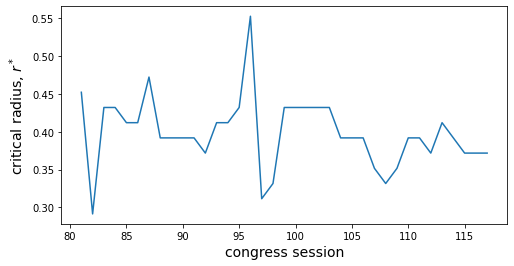

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

ax.plot(sessions, rs[mods.argmax(1)])
ax.set_ylabel('critical radius, $r^*$', fontsize = 14)
ax.set_xlabel('congress session', fontsize = 14)

r_crit = np.max(rs[mods.argmax(1)])

Given the critical radius, we plot the most recently completed Senate session:

(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

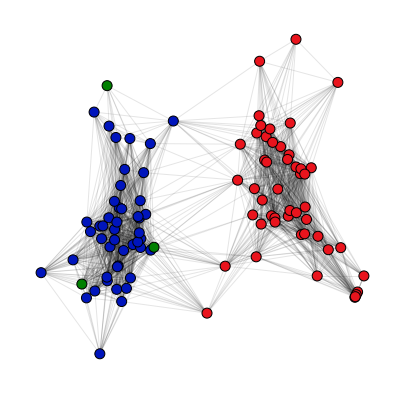

In [7]:
df = remove_insignificant_voters(dfs[dfs['congress'] == 117])
d, o = get_distance_matrix(df)
A = (d < r_crit).astype(int)
np.fill_diagonal(A, 0)
G = nx.from_numpy_array(A)

plot_networkx_graph(G, df, party_colors)

#### Edge betweenness dendogram

In this section, we compute the edge betweenness for the most recent Senate session graph and then generate a dendogram. To convert edge betweenness to a distance proxy, we normalize it and project the data into $[0, 1]$ where $0$ is the most between and $1$ is the least between.

In [15]:
edge_betweenness = nx.edge_betweenness(G)

In [16]:
eb = np.array(list(edge_betweenness.values()))

eb = 1 - (eb - eb.min())/(eb.max() - eb.min())

In [17]:
D = np.zeros_like(A, dtype = float)

for idx, edge in enumerate(edge_betweenness.keys()):
    i, j = edge
    D[i, j] = D[j, i] = eb[idx]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9944\2030603004.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  R = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.linkage(D));


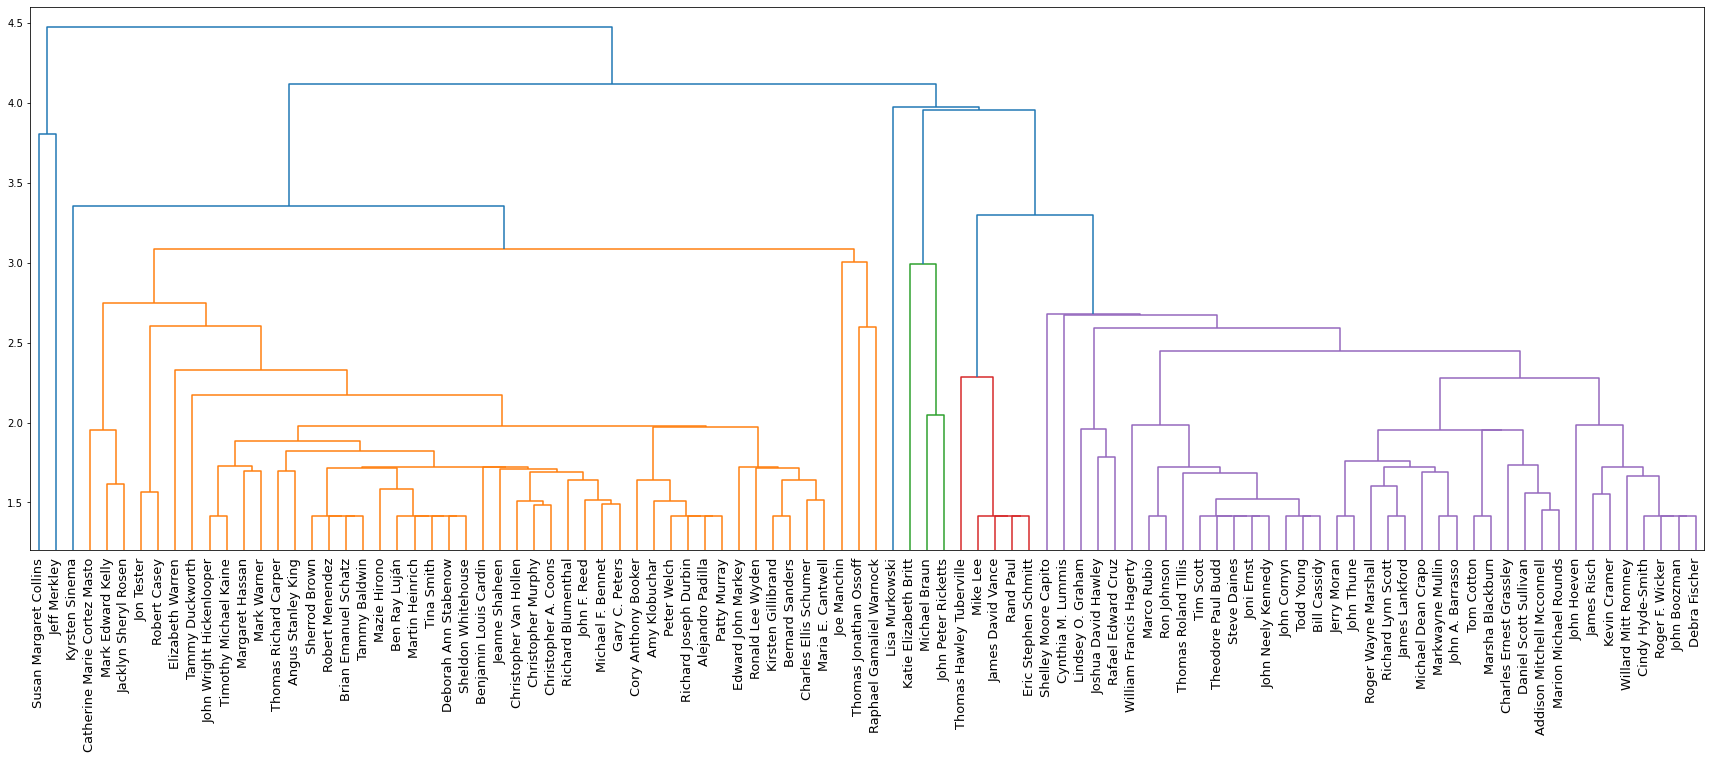

In [18]:
import scipy.cluster.hierarchy

fig, ax = plt.subplots(1, 1, figsize = (30, 10))
R = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.linkage(D));

node_order = R['leaves']
plt.ylim(1.2, 4.6)

ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(np.array(nodes)[np.array(node_order)], fontsize = 13);

#### Node betweenness

In this section, we compute the node betweenness across all Senate graphs for the sessions previously described.  First, we consider local values and project by a similar process as the edge betweenness.  The rationale is that somebody that is most between is important, i.e. 0.  Additionally, the lack of many high betweenness individual suggests the presence of strong community structure.

In [19]:
sessions = np.arange(81, 118)

master_dict = {}

means = []

eps = 0.05
high_bet = []

min_bet = 0
max_bet = 0

for sess in sessions:
    print('On Congress {}'.format(sess), '\r', end = '')
    df = remove_insignificant_voters(dfs[dfs['congress'] == sess])
    
    d, o = get_distance_matrix(df)

    A = (d < r_crit).astype(int)
    np.fill_diagonal(A, 0)

    G = nx.from_numpy_array(A)
    
    nodes = np.array(df['bioname'])
    nodes = [node.title().split(', ') for node in nodes]
    nodes = [node[1].split(' (')[0] + ' ' + node[0] for node in nodes]
    
    betweenness_dict = {name: val for name, val in zip(nodes, nx.betweenness_centrality(G).values())}
    
    temp = np.array(list(betweenness_dict.values()))
    
    if np.max(temp) > max_bet:
        max_bet = np.max(temp)
    
    normalized_dict = {name: val for name, val in zip(nodes, temp)}
    
    for node in nodes:
        if node not in master_dict:
            master_dict[node] = {}
            
        master_dict[node][sess] = normalized_dict[node]
        
    means.append(temp.mean())
    high_bet.append(np.mean((temp > 1 - eps)))

We then find the global maximum and minimum node betweenness and normalize each value according to this, so that we have a frame of reference to who and where the most and least between individuals were and subsequently how this changes over time.

In [20]:
sessions = np.arange(81, 118)

master_dict = {}

means = []

eps = 0.05
high_bet = []


for sess in sessions:
    print('On Congress {}'.format(sess), '\r', end = '')
    df = remove_insignificant_voters(dfs[dfs['congress'] == sess])
    
    d, o = get_distance_matrix(df)

    A = (d < r_crit).astype(int)
    np.fill_diagonal(A, 0)

    G = nx.from_numpy_array(A)
    
    nodes = np.array(df['bioname'])
    nodes = [node.title().split(', ') for node in nodes]
    nodes = [node[1].split(' (')[0] + ' ' + node[0] for node in nodes]
    
    betweenness_dict = {name: val for name, val in zip(nodes, nx.betweenness_centrality(G).values())}
    
    temp = np.array(list(betweenness_dict.values()))
    temp = 1 - (temp - min_bet)/(max_bet - min_bet)
    
    normalized_dict = {name: val for name, val in zip(nodes, temp)}
    
    for node in nodes:
        if node not in master_dict:
            master_dict[node] = {}
            
        master_dict[node][sess] = normalized_dict[node]
        
    means.append(temp.mean())
    high_bet.append(np.mean((temp > 1 - eps)))

We highlight a select few people to show the infrequency of between senators, i.e. the presence of community structure.

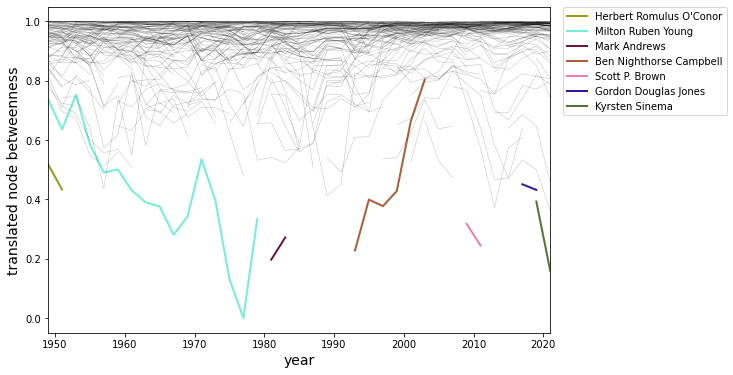

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6))

import random

min_sess = np.inf
max_sess = 0

for idx, (key, value) in enumerate(master_dict.items()):
    
    bets = np.array(list(value.values()))
    sess = np.array(list(value.keys()))
    
    years = 1789 + 2*(sess - 1)
    
    if np.min(years) < min_sess:
        min_sess = np.min(years)
        
    if np.max(years) > max_sess:
        max_sess = np.max(years)
    
    if np.mean(bets) < 0.5:
        plt.plot(years, bets, lw = 2, alpha = 1, label = key, c = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                )    
    else:
        plt.plot(years, bets, lw = 0.5, c = 'k', alpha = 0.25)
        
fig.legend(bbox_to_anchor = [1.18, 0.89], fontsize = 10)

ax.set_xlim(min_sess, max_sess)
ax.set_ylabel('translated node betweenness', fontsize = 14)
ax.set_xlabel('year', fontsize = 14)

fig.savefig('time.png')

Additionally, we compute mean betweenness and see that it does not change significantly over time; howevever, in contrast we also compute the fraction of senators near 1 betweenness to show that the increasing value over time suggests that senators are retreating into their political parties; hence, the presence of between senators is necessary for inter-party communication.

(1949.0, 2021.0)

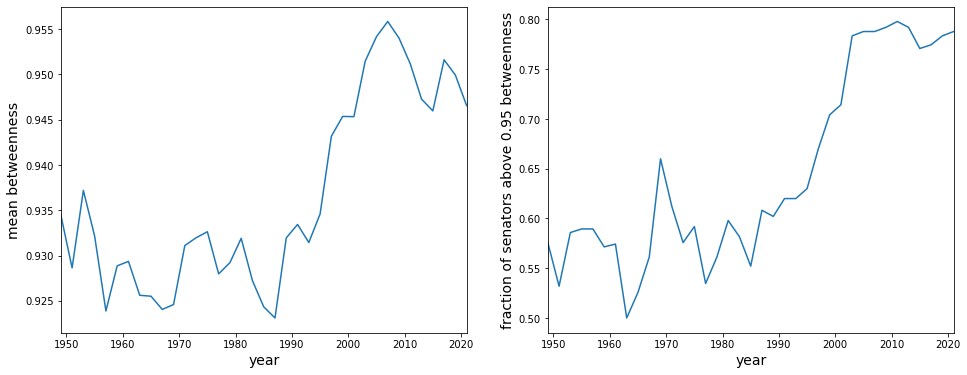

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

ax1.plot(1789 + 2*(sessions - 1), means)
ax1.set_ylabel('mean betweenness', fontsize = 14)
ax1.set_xlabel('year', fontsize = 14)
ax1.set_xlim(min_sess, max_sess)


ax2.plot(1789 + 2*(sessions - 1), high_bet)
ax2.set_ylabel('fraction of senators above {} betweenness'.format(1 - eps), fontsize = 14)
ax2.set_xlabel('year', fontsize = 14)
ax2.set_xlim(min_sess, max_sess)